In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (13, 5)
plt.rcParams["lines.linewidth"] = 0.5


In [2]:
from pathlib import os

file = "luzon_ts.csv"
path = os.path.join(os.path.realpath(".."), "datasets", file)

df = pd.read_csv(path, index_col="Date", parse_dates=True)
ts = df.Luzon_load
ts_train = ts[ts.index.year < 2022]
ts_test = ts[ts.index.year == 2022]
df


,Luzon_load
Date,
2013-01-01 00:00:00,4303
2013-01-01 01:00:00,3918
2013-01-01 02:00:00,3709
2013-01-01 03:00:00,3529
2013-01-01 04:00:00,3450
...,...
2022-12-31 19:00:00,7234
2022-12-31 20:00:00,6952
2022-12-31 21:00:00,6785


<AxesSubplot: xlabel='Date'>

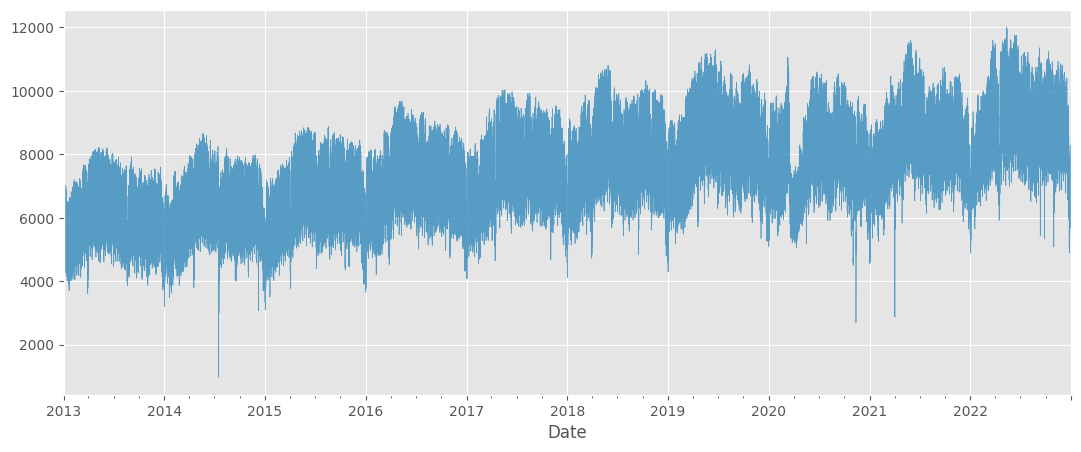

In [3]:
ts.plot(alpha=0.8, color="C1")

We see a roughly linear trend with yearly seasonality. <br>
We see that the effects of the start of the pandemic is heavily felt in 2020 as seen with the major drop in demand in the month of March

<AxesSubplot: xlabel='Date'>

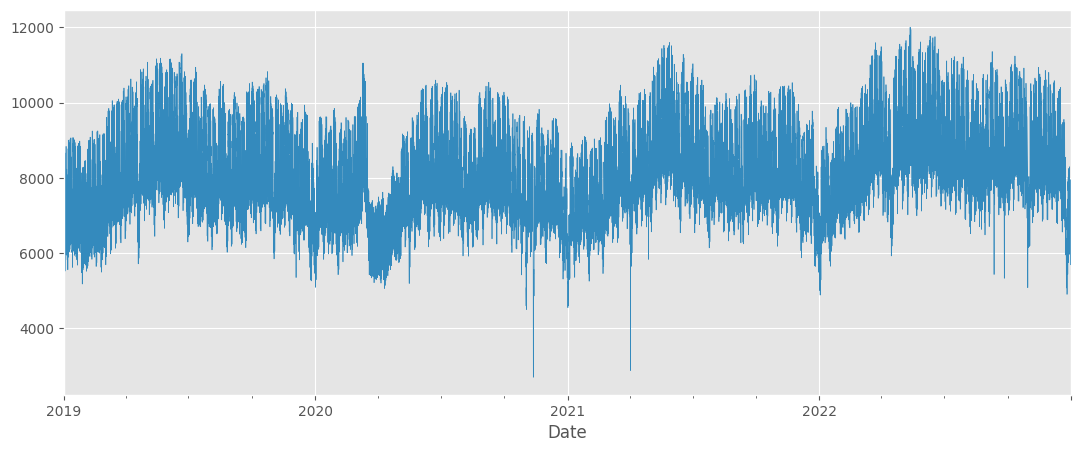

In [4]:
ts[ts.index.year >= 2019].plot(color="C1")

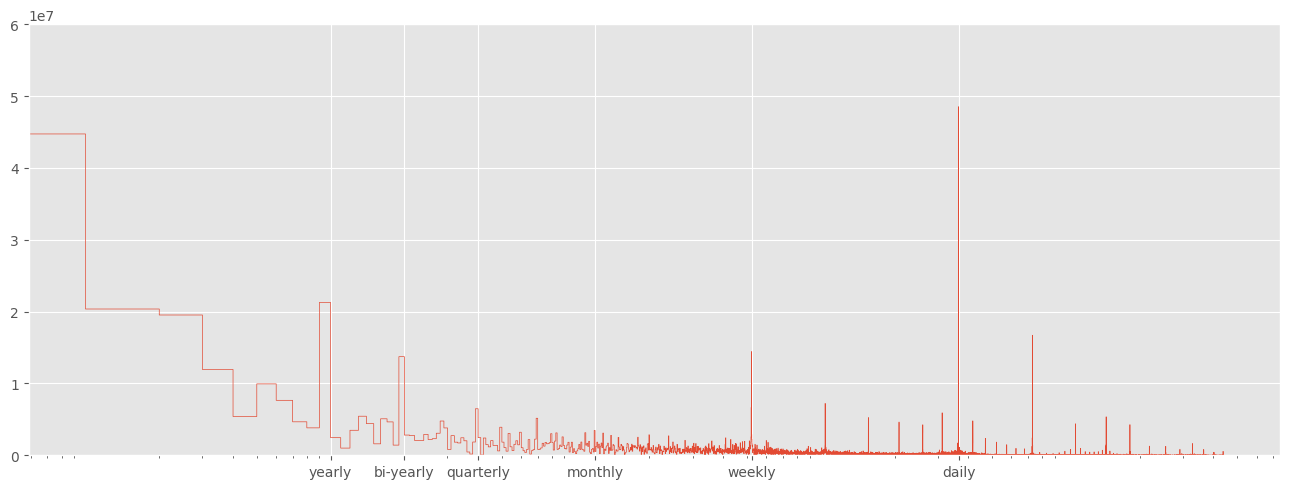

In [5]:
from scipy.fft import rfft

ts_fft = np.abs(rfft(ts))
f_ts = np.arange(0, len(ts_fft))

n_samples_h = len(ts)
hours_per_year = 365.2524 * 24

years_per_ts = n_samples_h / hours_per_year
f_per_year = f_ts / years_per_ts

plt.step(f_per_year, ts_fft)
plt.xscale("log")
plt.ylim(0, 0.6e8)
plt.xticks([1, 4, 365.2524, 2, 12, 52.2],
          ["yearly", "quarterly", "daily", "bi-yearly", "monthly", "weekly"])
plt.tight_layout()
plt.show()

We see that we have multiple seasonality in the data. We will model the daily and weekly seasonality as one-hot encoded vectors while the yearly to quarterly seasonality will be modelled by fourier features.

In [11]:
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.deterministic import CalendarFourier

class DeterministicFeatures():
    
    def __init__(self, ts=None, exog=None, ts_index=None):
        self.ts = ts
        self.ts_index = ts_index
        self.exog = exog
        
        if ts is not None:
            self.ts = ts.copy()
        
        if exog is not None:
            self.exog = exog.copy()
        
        if ts_index is None:
            self.ts_index = ts.index
            
        self.X = None
        self.encoder_daily = None
        self.encoder_weekly = None
    
    def create_df(self, ts_index=None, return_ts=False):
        if ts_index is None:
            ts_index = self.ts_index
            
        trend = self.create_linear_trend(ts_index)
        daily = self.create_daily_seasonality()
        weekly = self.create_weekly_seasonality()
        fourier = self.create_fourier()
        df = pd.concat([trend, daily, weekly, fourier], axis=1)
        if return_ts:
            return df, self.ts
        return df
   
    def create_linear_trend(self, index=None):
        df_trend = pd.DataFrame()
        df_trend["trend"] = np.arange(len(index))
        df_trend.index = index
        
        return df_trend
        
    def create_daily_seasonality(self, index=None):
        if index is None:
            index = self.ts_index
            
        if self.encoder_daily is None:
            self.encoder_daily = OneHotEncoder(drop="first", sparse_output=False, )
            
        df_hours = pd.DataFrame(index.hour)
        df_hours.index = index
        df_hours.columns = ["hour"]
        
        daily_encodings = self.encoder_daily.fit_transform(df_hours)
        daily_encodings = pd.DataFrame(daily_encodings, 
                                       columns=self.encoder_daily.get_feature_names_out(), 
                                       index=index)
        
        return daily_encodings
    
    def create_weekly_seasonality(self, index=None):
        if index is None:
            index = self.ts_index
        if self.encoder_weekly is None:
            self.encoder_weekly = OneHotEncoder(drop="first", sparse_output=False)
        
        df_weeks = pd.DataFrame(index.dayofweek)
        df_weeks.index = index
        df_weeks.columns = ["day+"]
        
        weekly_encodings = self.encoder_weekly.fit_transform(df_weeks)
        weekly_encodings = pd.DataFrame(weekly_encodings,
                                       columns=self.encoder_weekly.get_feature_names_out(),
                                       index=index)
        
        return weekly_encodings
    
    def create_fourier(self, index=None, order=4):
        if index is None:
            index = self.ts_index
        fourier = CalendarFourier(freq="Y", order=order)
        in_samples = fourier.in_sample(index)
        
        return in_samples

In [19]:
from sklearn.linear_model import LinearRegression

ts_train = ts[ts.index.year < 2022]
feats = DeterministicFeatures(ts_index=ts_train.index)
X_train = feats.create_df()

lm = LinearRegression().fit(X_train, ts_train)

<AxesSubplot: xlabel='Date'>

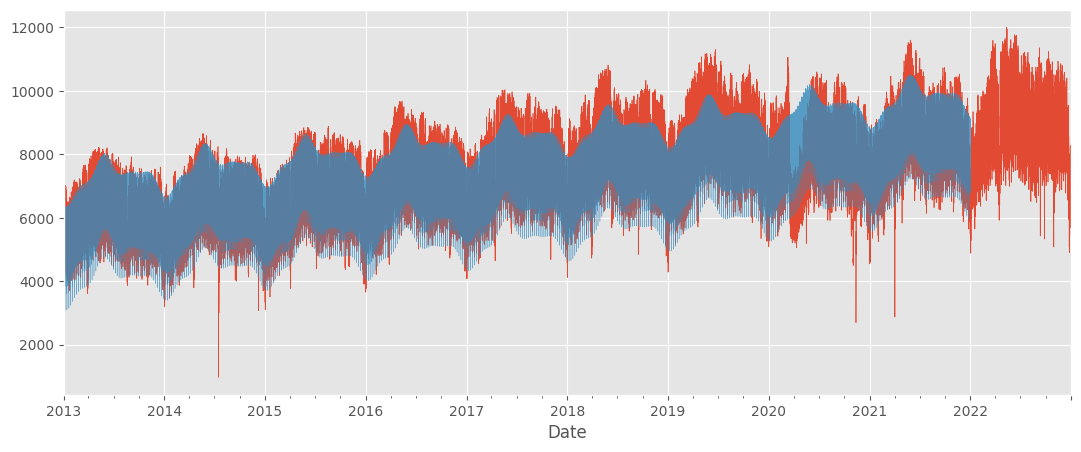

In [18]:
preds = pd.Series(lm.predict(X_train), index=ts_train.index)

ts.plot()
preds.plot(alpha=0.8, linewidth=0.3)


In [26]:
file_temp = "tempmax_PHL_1901-2021.csv"
path2 = os.path.join(os.path.realpath(".."), "datasets", file_temp)
temp_data = pd.read_csv(path2, skiprows=2, index_col=0)
temp_data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1901,29.81,28.93,30.45,32.07,32.11,31.02,30.34,29.79,30.34,30.16,29.73,28.95
1902,29.54,28.29,30.97,31.90,32.15,30.94,30.10,30.03,29.84,30.09,30.00,29.70
1903,28.90,28.19,30.26,31.21,31.23,31.24,30.06,30.23,30.05,29.39,28.99,27.77
1904,28.03,27.98,29.84,30.43,30.69,29.88,28.92,29.08,29.28,29.42,28.64,28.02
1905,29.48,29.15,30.28,31.13,31.42,30.02,28.96,29.57,29.06,29.35,29.02,29.68
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,28.92,28.97,30.14,31.60,31.95,30.97,30.43,30.67,30.65,30.21,30.26,29.33
2018,28.74,29.53,31.22,32.15,32.46,30.94,30.47,30.47,30.95,30.91,30.55,29.81
2019,29.33,29.98,31.15,32.15,32.38,31.71,30.29,30.08,30.35,30.82,30.41,29.86
2020,29.83,30.02,30.88,32.03,32.22,31.28,30.96,30.71,31.27,30.24,30.27,30.15


In [ ]:
l = 0.65
preds = (l * preds + 1) ** (1/l)

ts_train.tail(8760).plot()
preds.tail(8760).plot()

In [ ]:
df_train = df[df.index.year < 2022].copy()
df_train.columns = ["y"]
df_train["ds"] = df_train.index
model = Prophet(df=df_train,
               yearly.seasonality=4,
               weekly.seasonality=True,
               daily.seasonality=True,
               )
model.fit()

In [ ]:
ts_train

In [ ]:
df_train

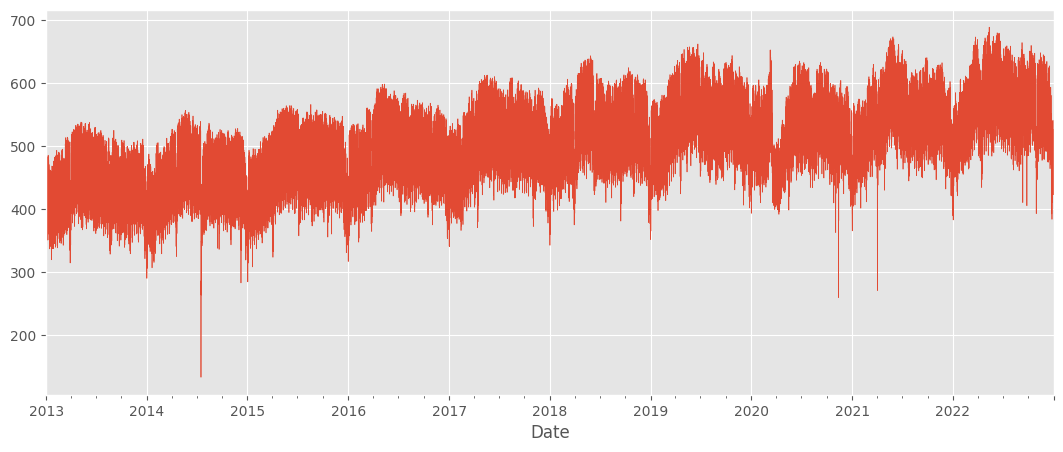

In [13]:
def box_cox(ts, l, plot=True):
    if l == 0:
        np.log(ts).plot()
        return np.log(ts)
    
    res = (ts ** l - 1) / l
    res.plot()
    return res

res = box_cox(ts, 0.65)

<AxesSubplot: xlabel='Date'>

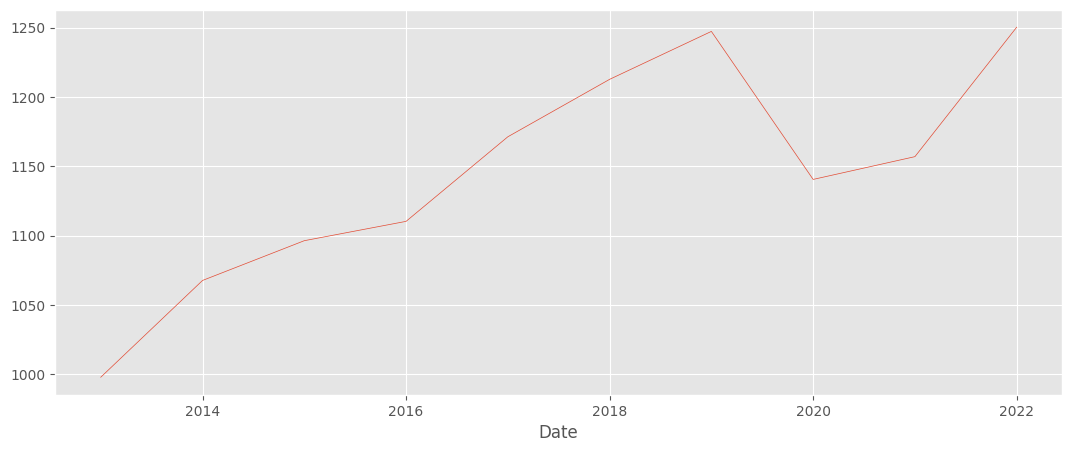

In [14]:
ts.groupby(ts.index.year).std().plot()

<AxesSubplot: xlabel='Date'>

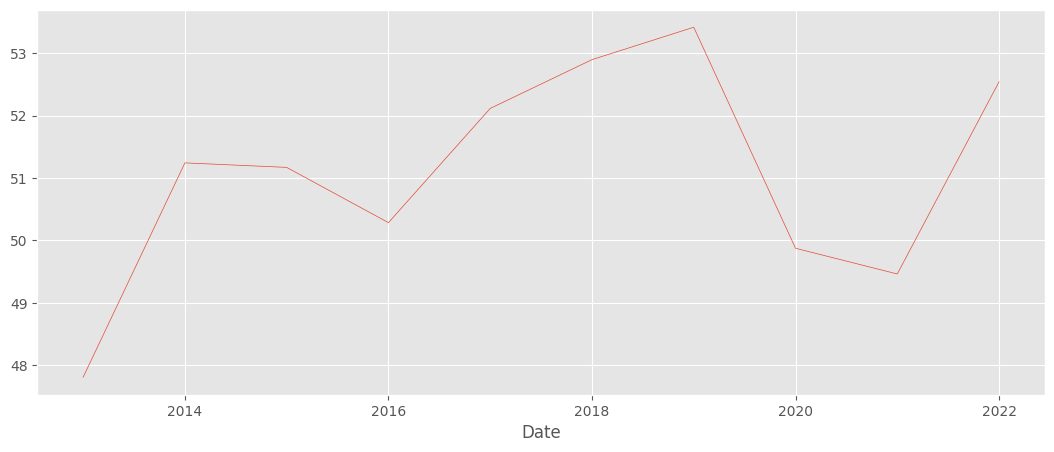

In [15]:
res.groupby(res.index.year).std().plot()

In [ ]:
np.arange(5)